# Creating and Backtesting simple Momentum/Contrarian Strategies

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

In [7]:
data = pd.read_csv("intraday.csv", parse_dates = ["time"], index_col = "time")
data

,EURUSD
time,
2018-01-01 22:00:00+00:00,1.201205
2018-01-02 04:00:00+00:00,1.207055
2018-01-02 10:00:00+00:00,1.204440
2018-01-02 16:00:00+00:00,1.205800
2018-01-02 22:00:00+00:00,1.204690
...,...
2019-12-29 22:00:00+00:00,1.119920
2019-12-30 04:00:00+00:00,1.119940
2019-12-30 10:00:00+00:00,1.120095


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2070 entries, 2018-01-01 22:00:00+00:00 to 2019-12-30 22:00:00+00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EURUSD  2070 non-null   float64
dtypes: float64(1)
memory usage: 32.3 KB


<Axes: title={'center': 'EUR/USD'}, xlabel='time'>

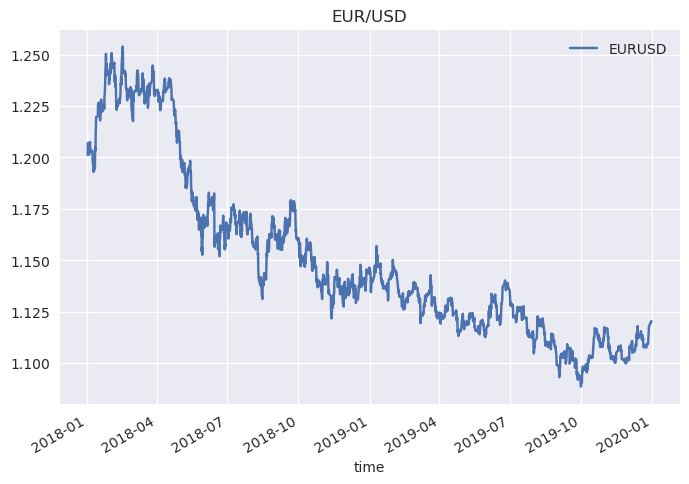

In [9]:
data.plot(title = "EUR/USD")

<Axes: title={'center': 'EUR/USD'}, xlabel='time'>

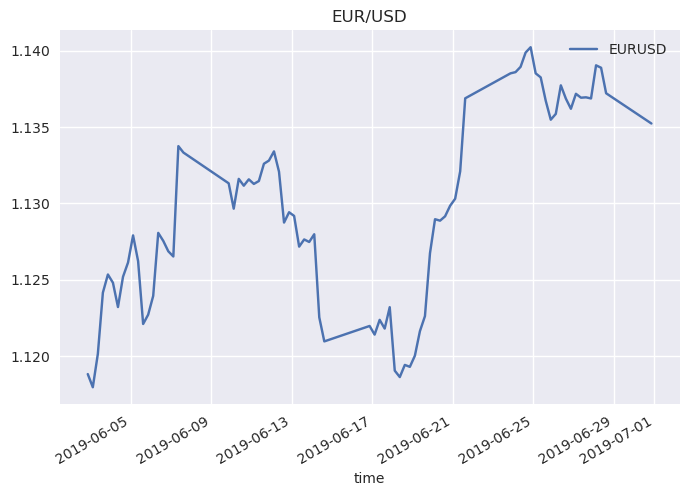

In [10]:
data.loc["2019-06"].plot(title = "EUR/USD")

In [11]:
data["Returns"] = np.log(data.div(data.shift(1)))
data.dropna(inplace = True)
data

,EURUSD,Returns
time,,
2018-01-02 04:00:00+00:00,1.207055,0.004858
2018-01-02 10:00:00+00:00,1.204440,-0.002169
2018-01-02 16:00:00+00:00,1.205800,0.001129
2018-01-02 22:00:00+00:00,1.204690,-0.000921
2018-01-03 04:00:00+00:00,1.203825,-0.000718
...,...,...
2019-12-29 22:00:00+00:00,1.119920,0.002092
2019-12-30 04:00:00+00:00,1.119940,0.000018
2019-12-30 10:00:00+00:00,1.120095,0.000138


## Intro to Backtesting: a Buy-and-Hold "Strategy"

Assumption: invest $1 in instrument EURUSD on 2018-01-02 and hold until 2019-12-30 (no further traders).

<Axes: xlabel='time'>

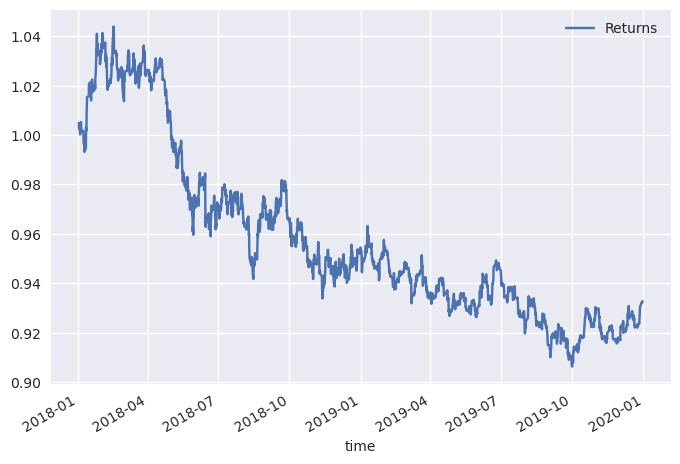

In [12]:
data[["Returns"]].cumsum().apply(np.exp).plot() # normalised price with Base == 1

In [13]:
multiple = data[["Returns"]].sum().apply(np.exp)
multiple

Returns    0.932693
dtype: float64

In [14]:
data.Returns.mean() # 6h mean return

-3.367792182329036e-05

In [15]:
data.Returns.std() # std of 6h return

0.001888428384199011

## Defining a simple Contrarian Strategy (window = 3)

In [16]:
window = 3

In [17]:
data["Returns"].rolling(window).mean()

time
2018-01-02 04:00:00+00:00             NaN
2018-01-02 10:00:00+00:00             NaN
2018-01-02 16:00:00+00:00    1.272676e-03
2018-01-02 22:00:00+00:00   -6.537454e-04
2018-01-03 04:00:00+00:00   -1.702470e-04
                                 ...     
2019-12-29 22:00:00+00:00    1.808598e-03
2019-12-30 04:00:00+00:00    1.085156e-03
2019-12-30 10:00:00+00:00    7.492899e-04
2019-12-30 16:00:00+00:00   -1.484453e-17
2019-12-30 22:00:00+00:00    1.234956e-04
Name: Returns, Length: 2069, dtype: float64

In [18]:
data["Position"] = -np.sign(data["Returns"].rolling(window).mean()) # contrarian (minus sign)
data

,EURUSD,Returns,Position
time,,,
2018-01-02 04:00:00+00:00,1.207055,0.004858,NaN
2018-01-02 10:00:00+00:00,1.204440,-0.002169,NaN
2018-01-02 16:00:00+00:00,1.205800,0.001129,-1.0
2018-01-02 22:00:00+00:00,1.204690,-0.000921,1.0
2018-01-03 04:00:00+00:00,1.203825,-0.000718,1.0
...,...,...,...
2019-12-29 22:00:00+00:00,1.119920,0.002092,-1.0
2019-12-30 04:00:00+00:00,1.119940,0.000018,-1.0
2019-12-30 10:00:00+00:00,1.120095,0.000138,-1.0


## Vectorised Strategy Backtesting

In [19]:
data["Strategy"] = data.Position.shift(1) * data.Returns # position to take for the next bar (candle) - use shift(1)
data

,EURUSD,Returns,Position,Strategy
time,,,,
2018-01-02 04:00:00+00:00,1.207055,0.004858,NaN,NaN
2018-01-02 10:00:00+00:00,1.204440,-0.002169,NaN,NaN
2018-01-02 16:00:00+00:00,1.205800,0.001129,-1.0,NaN
2018-01-02 22:00:00+00:00,1.204690,-0.000921,1.0,0.000921
2018-01-03 04:00:00+00:00,1.203825,-0.000718,1.0,-0.000718
...,...,...,...,...
2019-12-29 22:00:00+00:00,1.119920,0.002092,-1.0,-0.002092
2019-12-30 04:00:00+00:00,1.119940,0.000018,-1.0,-0.000018
2019-12-30 10:00:00+00:00,1.120095,0.000138,-1.0,-0.000138


In [20]:
data.dropna(inplace = True)
data

,EURUSD,Returns,Position,Strategy
time,,,,
2018-01-02 22:00:00+00:00,1.204690,-0.000921,1.0,0.000921
2018-01-03 04:00:00+00:00,1.203825,-0.000718,1.0,-0.000718
2018-01-03 10:00:00+00:00,1.202355,-0.001222,1.0,-0.001222
2018-01-03 16:00:00+00:00,1.201445,-0.000757,1.0,-0.000757
2018-01-03 22:00:00+00:00,1.201450,0.000004,1.0,0.000004
...,...,...,...,...
2019-12-29 22:00:00+00:00,1.119920,0.002092,-1.0,-0.002092
2019-12-30 04:00:00+00:00,1.119940,0.000018,-1.0,-0.000018
2019-12-30 10:00:00+00:00,1.120095,0.000138,-1.0,-0.000138


In [21]:
data[["Returns", "Strategy"]].sum().apply(np.exp) # multiple for buy-and-hold and strategy

Returns     0.929138
Strategy    1.101019
dtype: float64

In [22]:
data["creturns"] = data["Returns"].cumsum().apply(np.exp)  # normalized price with base = 1 for buy-and-hold
data["cstrategy"] = data["Strategy"].cumsum().apply(np.exp) # normalized price with base = 1 for strategy

<Axes: xlabel='time'>

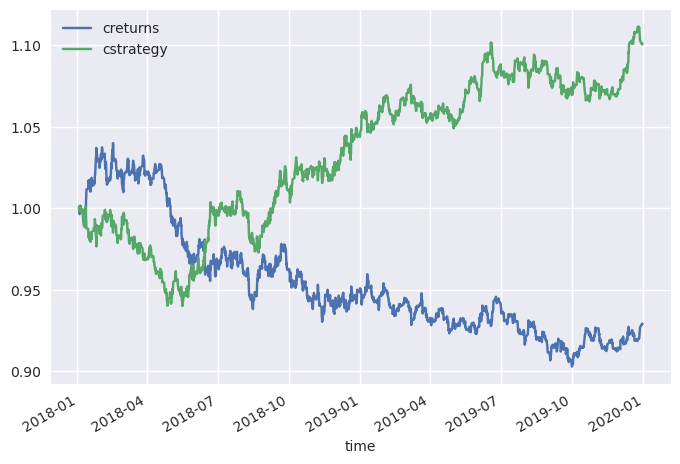

In [23]:
data[["creturns", "cstrategy"]].plot()

In [24]:
tp_year = data.Returns.count() / ((data.index[-1] - data.index[0]).days / 365.25) # 6h trading periods
tp_year

1037.9731774415407

In [25]:
data[["Returns", "Strategy"]].mean() * tp_year # annualised returns

Returns    -0.036926
Strategy    0.048350
dtype: float64

In [26]:
data[["Returns", "Strategy"]].std() * np.sqrt(tp_year) # annualised stf

Returns     0.060761
Strategy    0.060754
dtype: float64

All long/short trading strategies (either -1 or 1) based on the underlying instrument have the same risk.
Risk (std) can be reduced with **neutral positions (0)**.

### Changing the window parameter

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

In [28]:
data = pd.read_csv("intraday.csv", parse_dates = ["time"], index_col = "time")
data

,EURUSD
time,
2018-01-01 22:00:00+00:00,1.201205
2018-01-02 04:00:00+00:00,1.207055
2018-01-02 10:00:00+00:00,1.204440
2018-01-02 16:00:00+00:00,1.205800
2018-01-02 22:00:00+00:00,1.204690
...,...
2019-12-29 22:00:00+00:00,1.119920
2019-12-30 04:00:00+00:00,1.119940
2019-12-30 10:00:00+00:00,1.120095


In [29]:
data["returns"] = np.log(data.div(data.shift(1)))
data.dropna(inplace = True)
data

,EURUSD,returns
time,,
2018-01-02 04:00:00+00:00,1.207055,0.004858
2018-01-02 10:00:00+00:00,1.204440,-0.002169
2018-01-02 16:00:00+00:00,1.205800,0.001129
2018-01-02 22:00:00+00:00,1.204690,-0.000921
2018-01-03 04:00:00+00:00,1.203825,-0.000718
...,...,...
2019-12-29 22:00:00+00:00,1.119920,0.002092
2019-12-30 04:00:00+00:00,1.119940,0.000018
2019-12-30 10:00:00+00:00,1.120095,0.000138


In [30]:
to_plot = ["returns"]

In [31]:
for w in [1, 2, 3, 5, 10]:
    data["position{}".format(w)] = -np.sign(data["returns"].rolling(w).mean())
    data["strategy{}".format(w)] = data["position{}".format(w)].shift(1) * data["returns"]
    to_plot.append("strategy{}".format(w))

In [32]:
data

,EURUSD,returns,position1,strategy1,position2,strategy2,position3,strategy3,position5,strategy5,position10,strategy10
time,,,,,,,,,,,,
2018-01-02 04:00:00+00:00,1.207055,0.004858,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02 10:00:00+00:00,1.204440,-0.002169,1.0,0.002169,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02 16:00:00+00:00,1.205800,0.001129,-1.0,0.001129,1.0,-0.001129,-1.0,NaN,NaN,NaN,NaN,NaN
2018-01-02 22:00:00+00:00,1.204690,-0.000921,1.0,0.000921,-1.0,-0.000921,1.0,0.000921,NaN,NaN,NaN,NaN
2018-01-03 04:00:00+00:00,1.203825,-0.000718,1.0,-0.000718,1.0,0.000718,1.0,-0.000718,-1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-29 22:00:00+00:00,1.119920,0.002092,-1.0,-0.002092,-1.0,-0.002092,-1.0,-0.002092,-1.0,-0.002092,-1.0,-0.002092
2019-12-30 04:00:00+00:00,1.119940,0.000018,-1.0,-0.000018,-1.0,-0.000018,-1.0,-0.000018,-1.0,-0.000018,-1.0,-0.000018
2019-12-30 10:00:00+00:00,1.120095,0.000138,-1.0,-0.000138,-1.0,-0.000138,-1.0,-0.000138,-1.0,-0.000138,-1.0,-0.000138


In [33]:
to_plot

['returns', 'strategy1', 'strategy2', 'strategy3', 'strategy5', 'strategy10']

Text(0.5, 1.0, 'DJI Intraday - 6h bars')

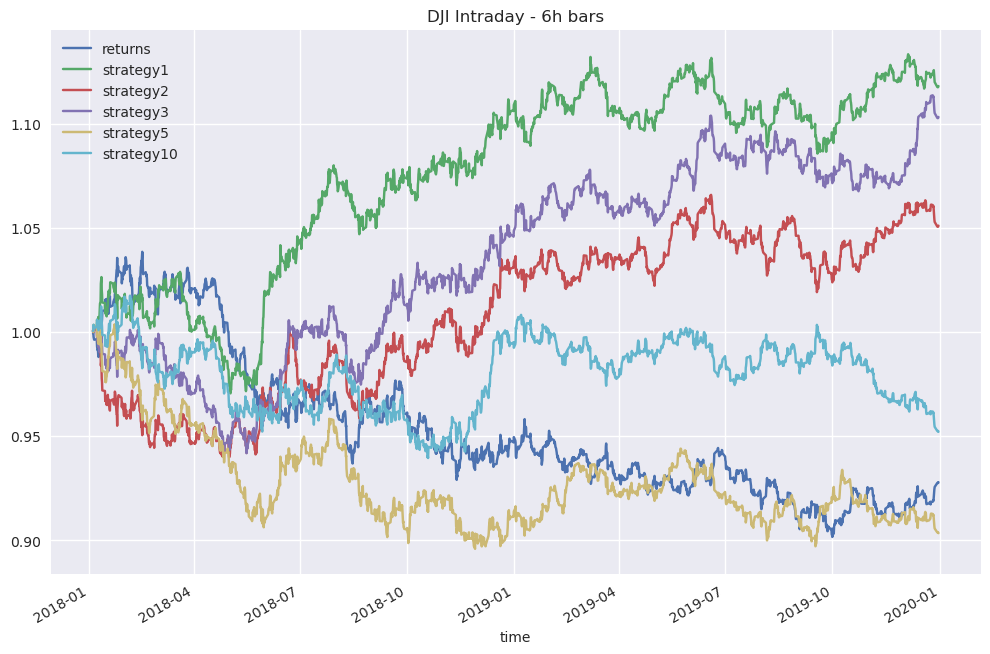

In [34]:
data[to_plot].dropna().cumsum().apply(np.exp).plot(figsize = (12, 8))
plt.title("DJI Intraday - 6h bars")

### Trades and trading costs

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

In [36]:
data = pd.read_csv("intraday.csv", parse_dates = ["time"], index_col = "time")
data

,EURUSD
time,
2018-01-01 22:00:00+00:00,1.201205
2018-01-02 04:00:00+00:00,1.207055
2018-01-02 10:00:00+00:00,1.204440
2018-01-02 16:00:00+00:00,1.205800
2018-01-02 22:00:00+00:00,1.204690
...,...
2019-12-29 22:00:00+00:00,1.119920
2019-12-30 04:00:00+00:00,1.119940
2019-12-30 10:00:00+00:00,1.120095


In [37]:
window = 3

In [38]:
data["returns"] = np.log(data.div(data.shift(1)))

In [39]:
data["position"] = -np.sign(data["returns"].rolling(window).mean())

In [40]:
data["strategy"] = data.position.shift(1) * data["returns"]

In [41]:
data

,EURUSD,returns,position,strategy
time,,,,
2018-01-01 22:00:00+00:00,1.201205,NaN,NaN,NaN
2018-01-02 04:00:00+00:00,1.207055,0.004858,NaN,NaN
2018-01-02 10:00:00+00:00,1.204440,-0.002169,NaN,NaN
2018-01-02 16:00:00+00:00,1.205800,0.001129,-1.0,NaN
2018-01-02 22:00:00+00:00,1.204690,-0.000921,1.0,0.000921
...,...,...,...,...
2019-12-29 22:00:00+00:00,1.119920,0.002092,-1.0,-0.002092
2019-12-30 04:00:00+00:00,1.119940,0.000018,-1.0,-0.000018
2019-12-30 10:00:00+00:00,1.120095,0.000138,-1.0,-0.000138


In [42]:
data.dropna(inplace = True)

In [43]:
data["creturns"] = data["returns"].cumsum().apply(np.exp)
data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)

In [44]:
data

,EURUSD,returns,position,strategy,creturns,cstrategy
time,,,,,,
2018-01-02 22:00:00+00:00,1.204690,-0.000921,1.0,0.000921,0.999079,1.000921
2018-01-03 04:00:00+00:00,1.203825,-0.000718,1.0,-0.000718,0.998362,1.000203
2018-01-03 10:00:00+00:00,1.202355,-0.001222,1.0,-0.001222,0.997143,0.998981
2018-01-03 16:00:00+00:00,1.201445,-0.000757,1.0,-0.000757,0.996388,0.998225
2018-01-03 22:00:00+00:00,1.201450,0.000004,1.0,0.000004,0.996392,0.998229
...,...,...,...,...,...,...
2019-12-29 22:00:00+00:00,1.119920,0.002092,-1.0,-0.002092,0.928778,1.100591
2019-12-30 04:00:00+00:00,1.119940,0.000018,-1.0,-0.000018,0.928794,1.100572
2019-12-30 10:00:00+00:00,1.120095,0.000138,-1.0,-0.000138,0.928923,1.100420


<Axes: xlabel='time'>

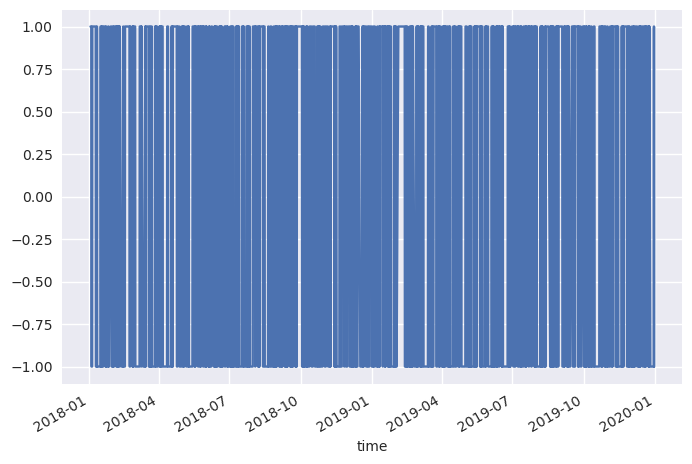

In [45]:
data.loc[:, "position"].plot()

<Axes: xlabel='time'>

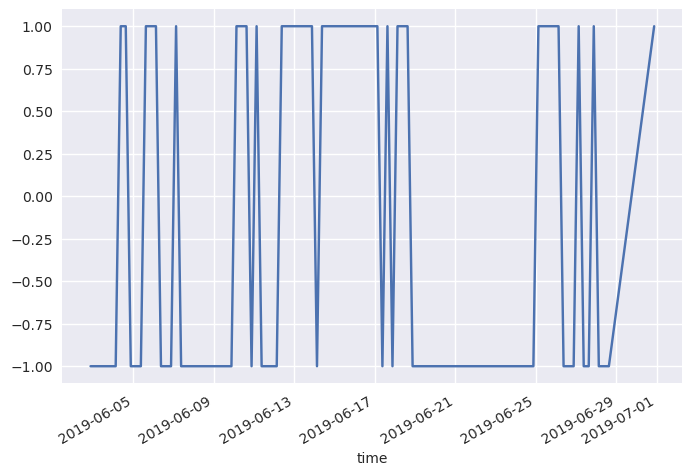

In [46]:
data.loc["2019--6", "position"].plot()

In [47]:
data.position.diff().fillna(0).abs() # absolute change in position

time
2018-01-02 22:00:00+00:00    0.0
2018-01-03 04:00:00+00:00    0.0
2018-01-03 10:00:00+00:00    0.0
2018-01-03 16:00:00+00:00    0.0
2018-01-03 22:00:00+00:00    0.0
                            ... 
2019-12-29 22:00:00+00:00    0.0
2019-12-30 04:00:00+00:00    0.0
2019-12-30 10:00:00+00:00    0.0
2019-12-30 16:00:00+00:00    2.0
2019-12-30 22:00:00+00:00    2.0
Name: position, Length: 2066, dtype: float64

In [48]:
data["trades"] = data.position.diff().fillna(0).abs()

In [49]:
data.trades.value_counts()

0.0    1513
2.0     553
Name: trades, dtype: int64

- 553 full trades (from short to long and viceversa)
- each trade triggers trading costs
- costs must be included in backtesting

## Trading costs

In [50]:
commissions = 0

In [51]:
spread = 1.5 * 0.0001 # pips == fourth price decimal

In [52]:
half_spread = spread / 2 # absolute costs per trade (position change +-1)
half_spread

7.500000000000001e-05

In [53]:
half_spread * 100_000 # absolute costs in USD when buying 100,000 units of EUR/USD

7.500000000000001

Proportional trading costs are more useful than absolute trading costs.
<br>
Goal: deduct proportional trading costs from strategy returns before costs.

In [54]:
ptc = half_spread / data.EURUSD.mean() # proportional costs per trade (position change +-1)
ptc

6.520065892008921e-05

In [55]:
ptc = 0.00007 # conservative approx.

In [56]:
data

,EURUSD,returns,position,strategy,creturns,cstrategy,trades
time,,,,,,,
2018-01-02 22:00:00+00:00,1.204690,-0.000921,1.0,0.000921,0.999079,1.000921,0.0
2018-01-03 04:00:00+00:00,1.203825,-0.000718,1.0,-0.000718,0.998362,1.000203,0.0
2018-01-03 10:00:00+00:00,1.202355,-0.001222,1.0,-0.001222,0.997143,0.998981,0.0
2018-01-03 16:00:00+00:00,1.201445,-0.000757,1.0,-0.000757,0.996388,0.998225,0.0
2018-01-03 22:00:00+00:00,1.201450,0.000004,1.0,0.000004,0.996392,0.998229,0.0
...,...,...,...,...,...,...,...
2019-12-29 22:00:00+00:00,1.119920,0.002092,-1.0,-0.002092,0.928778,1.100591,0.0
2019-12-30 04:00:00+00:00,1.119940,0.000018,-1.0,-0.000018,0.928794,1.100572,0.0
2019-12-30 10:00:00+00:00,1.120095,0.000138,-1.0,-0.000138,0.928923,1.100420,0.0


In [57]:
# sometimes we don't have trades, sometimes we have 2
data["strategy_net"] = data.strategy - data.trades * ptc # strategy returns net of costs

In [58]:
data["cstrategy_net"] = data.strategy_net.cumsum().apply(np.exp)

In [59]:
data

,EURUSD,returns,position,strategy,creturns,cstrategy,trades,strategy_net,cstrategy_net
time,,,,,,,,,
2018-01-02 22:00:00+00:00,1.204690,-0.000921,1.0,0.000921,0.999079,1.000921,0.0,0.000921,1.000921
2018-01-03 04:00:00+00:00,1.203825,-0.000718,1.0,-0.000718,0.998362,1.000203,0.0,-0.000718,1.000203
2018-01-03 10:00:00+00:00,1.202355,-0.001222,1.0,-0.001222,0.997143,0.998981,0.0,-0.001222,0.998981
2018-01-03 16:00:00+00:00,1.201445,-0.000757,1.0,-0.000757,0.996388,0.998225,0.0,-0.000757,0.998225
2018-01-03 22:00:00+00:00,1.201450,0.000004,1.0,0.000004,0.996392,0.998229,0.0,0.000004,0.998229
...,...,...,...,...,...,...,...,...,...
2019-12-29 22:00:00+00:00,1.119920,0.002092,-1.0,-0.002092,0.928778,1.100591,0.0,-0.002092,1.018884
2019-12-30 04:00:00+00:00,1.119940,0.000018,-1.0,-0.000018,0.928794,1.100572,0.0,-0.000018,1.018866
2019-12-30 10:00:00+00:00,1.120095,0.000138,-1.0,-0.000138,0.928923,1.100420,0.0,-0.000138,1.018725


<Axes: xlabel='time'>

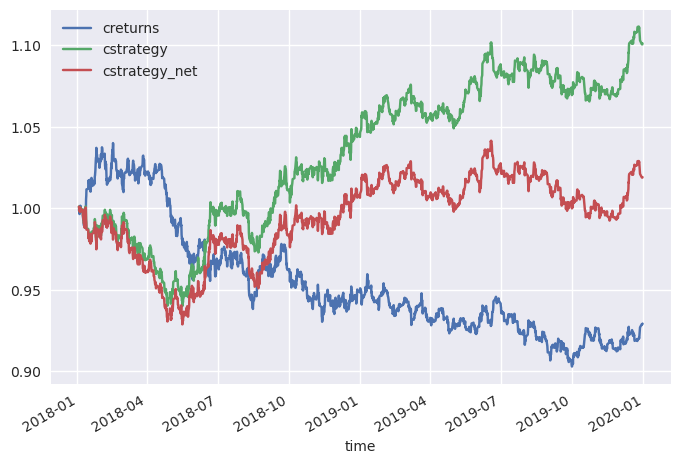

In [60]:
data[["creturns", "cstrategy", "cstrategy_net"]].plot()

## Generalization with OOP: the ConBacktester Class

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

In [62]:
# Version 1.0
class ConBacktester():
    ''' Class for the vectorized backtesting of simple contrarian trading strategies.
    
    Attributes
    ============
    filepath: str
        local filepath of the dataset (csv-file)
    symbol: str
        ticker symbol (instrument) to be backtested
    start: str
        start date for data import
    end: str
        end date for data import
    tc: float
        proportional trading costs per trade
    
    
    Methods
    =======
    get_data:
        imports the data.
        
    test_strategy:
        prepares the data and backtests the trading strategy incl. reporting (wrapper).
        
    prepare_data:
        prepares the data for backtesting.
    
    run_backtest:
        runs the strategy backtest.
        
    plot_results:
        plots the cumulative performance of the trading strategy compared to buy-and-hold.
    '''    
    
    def __init__(self, filepath, symbol, start, end, tc):
        
        self.filepath = filepath
        self.symbol = symbol
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None
        self.get_data()
        
    def __repr__(self):
        return "ConBacktester(symbol = {}, start = {}, end = {})".format(self.symbol, self.start, self.end)
        
    def get_data(self):
        ''' Imports the data.
        '''
        raw = pd.read_csv(self.filepath, parse_dates = ["time"], index_col = "time")
        raw = raw[self.symbol].to_frame().fillna(method = "ffill") 
        raw = raw.loc[self.start:self.end].copy()
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw.price / raw.price.shift(1))
        self.data = raw
        
    def test_strategy(self, window = 1):
        '''
        Prepares the data and backtests the trading strategy incl. reporting (Wrapper).
         
        Parameters
        ============
        window: int
            time window (number of bars) to be considered for the strategy.
        '''
        self.window = window
                                
        self.prepare_data(window)
        self.run_backtest()
        
        data = self.results.copy()
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        multiple = round(self.results.cstrategy[-1], 6)
        print("Strategy-Multiple: {}".format(multiple))
    
    def prepare_data(self, window):
        
        ''' Prepares the Data for Backtesting.
        '''
        data = self.data.copy()
        data["roll_return"] = data["returns"].rolling(window).mean()
        data["position"] = -np.sign(data["roll_return"])
        self.results = data
    
    def run_backtest(self):
        ''' Runs the strategy backtest.
        '''
        
        data = self.results.copy()
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data.dropna(inplace=True)
        
        # determine the number of trades in each bar
        data["trades"] = data.position.diff().fillna(0).abs()
        
        # subtract transaction/trading costs from pre-cost return
        data.strategy = data.strategy - data.trades * self.tc
        
        self.results = data
    
    def plot_results(self):
        '''  Plots the cumulative performance of the trading strategy compared to buy-and-hold.
        '''
        if self.results is None:
            print("Run test_strategy() first.")
        else:
            title = "{} | Window = {} | TC = {}".format(self.symbol, self.window, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))

In [63]:
symbol = "EURUSD"
start = "2018-01-01"
end = "2019-12-31"
tc = 0.00007

In [64]:
tester = ConBacktester(filepath="intraday.csv", symbol=symbol, start=start, end=end, tc=tc)
tester

ConBacktester(symbol = EURUSD, start = 2018-01-01, end = 2019-12-31)

In [65]:
tester.data

,price,returns
time,,
2018-01-01 22:00:00+00:00,1.201205,NaN
2018-01-02 04:00:00+00:00,1.207055,0.004858
2018-01-02 10:00:00+00:00,1.204440,-0.002169
2018-01-02 16:00:00+00:00,1.205800,0.001129
2018-01-02 22:00:00+00:00,1.204690,-0.000921
...,...,...
2019-12-29 22:00:00+00:00,1.119920,0.002092
2019-12-30 04:00:00+00:00,1.119940,0.000018
2019-12-30 10:00:00+00:00,1.120095,0.000138


In [71]:
tester.test_strategy(window = 1)

Strategy-Multiple: 0.963517


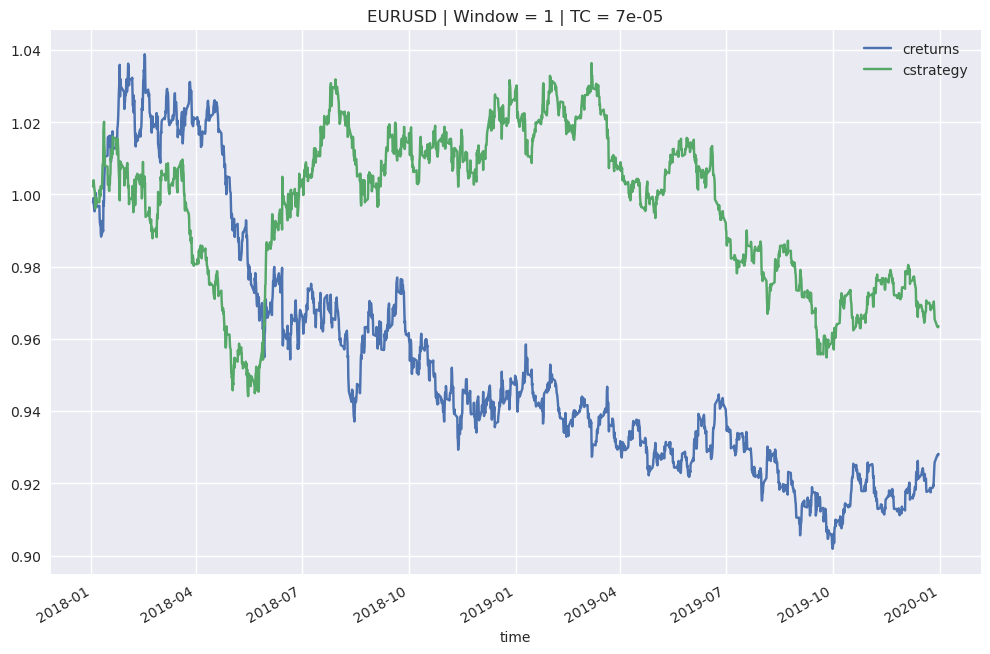

In [72]:
tester.plot_results()

In [73]:
tester.results

,price,returns,roll_return,position,strategy,trades,creturns,cstrategy
time,,,,,,,,
2018-01-02 10:00:00+00:00,1.204440,-0.002169,-0.002169,1.0,0.002169,0.0,0.997834,1.002171
2018-01-02 16:00:00+00:00,1.205800,0.001129,0.001129,-1.0,0.000989,2.0,0.998960,1.003162
2018-01-02 22:00:00+00:00,1.204690,-0.000921,-0.000921,1.0,0.000781,2.0,0.998041,1.003946
2018-01-03 04:00:00+00:00,1.203825,-0.000718,-0.000718,1.0,-0.000718,0.0,0.997324,1.003225
2018-01-03 10:00:00+00:00,1.202355,-0.001222,-0.001222,1.0,-0.001222,0.0,0.996106,1.002000
...,...,...,...,...,...,...,...,...
2019-12-29 22:00:00+00:00,1.119920,0.002092,0.002092,-1.0,-0.002092,0.0,0.927812,0.963413
2019-12-30 04:00:00+00:00,1.119940,0.000018,0.000018,-1.0,-0.000018,0.0,0.927828,0.963396
2019-12-30 10:00:00+00:00,1.120095,0.000138,0.000138,-1.0,-0.000138,0.0,0.927957,0.963262


In [70]:
tester.symbol

'EURUSD'